In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import spectral
from scipy import sparse
import scipy.sparse.linalg as spla

Let's try to solve viscous Burgers' equation:
$$ \partial_t u - \nu \partial_x^2 u = -u \partial_x u $$

What happens if we change the spatial resolution?

In [2]:
u_list = []
kx_list = []

In [3]:
x_basis = spectral.Fourier(128)
domain = spectral.Domain([x_basis])
dtype = np.complex128
u = spectral.Field(domain, dtype=dtype)
dudx = spectral.Field(domain, dtype=dtype)
RHS = spectral.Field(domain, dtype=dtype)

x = x_basis.grid()
u.require_grid_space()
u.data = 0.5*(np.sin(x)+1)

N = x_basis.N
kx = x_basis.wavenumbers(dtype)

nu = 1e-2
dt = 1e-2
t_end = 5
num_steps = int(t_end/dt)

<IPython.core.display.Javascript object>


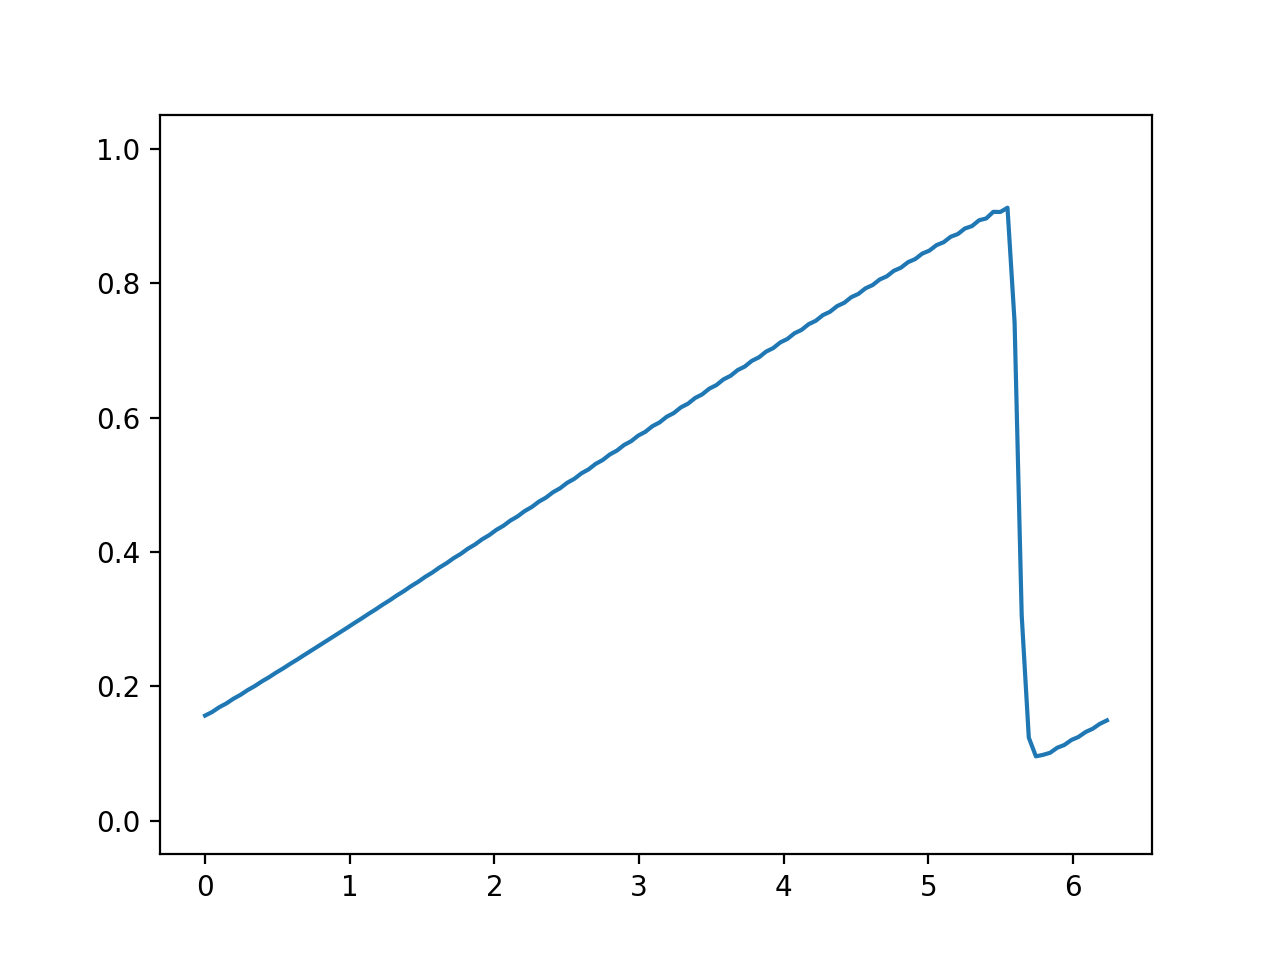

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [4]:
fig = plt.figure()
u.require_grid_space()
p, = plt.plot(x, u.data)
fig.canvas.draw()

for i in range(num_steps):
    # take a timestep:
    u.require_coeff_space()
    dudx.require_coeff_space()
    dudx.data = 1j*kx*u.data
    u.require_grid_space(scales=2)
    dudx.require_grid_space(scales=2)
    RHS.require_grid_space(scales=2)
    RHS.data = -u.data * dudx.data
    RHS.require_coeff_space()

    diag = 1/dt + nu*kx**2
    LHS = sparse.diags(diag)
    u.require_coeff_space()
    RHS.data += u.data/dt
    u.data = spla.spsolve(LHS, RHS.data)
    
    if i % 5 == 0:
        u.require_grid_space()
        p.set_ydata(u.data.real)
        fig.canvas.draw()

In [5]:
u.require_coeff_space()
u_list.append(u.data)
kx_list.append(x_basis.wavenumbers(dtype))

<IPython.core.display.Javascript object>


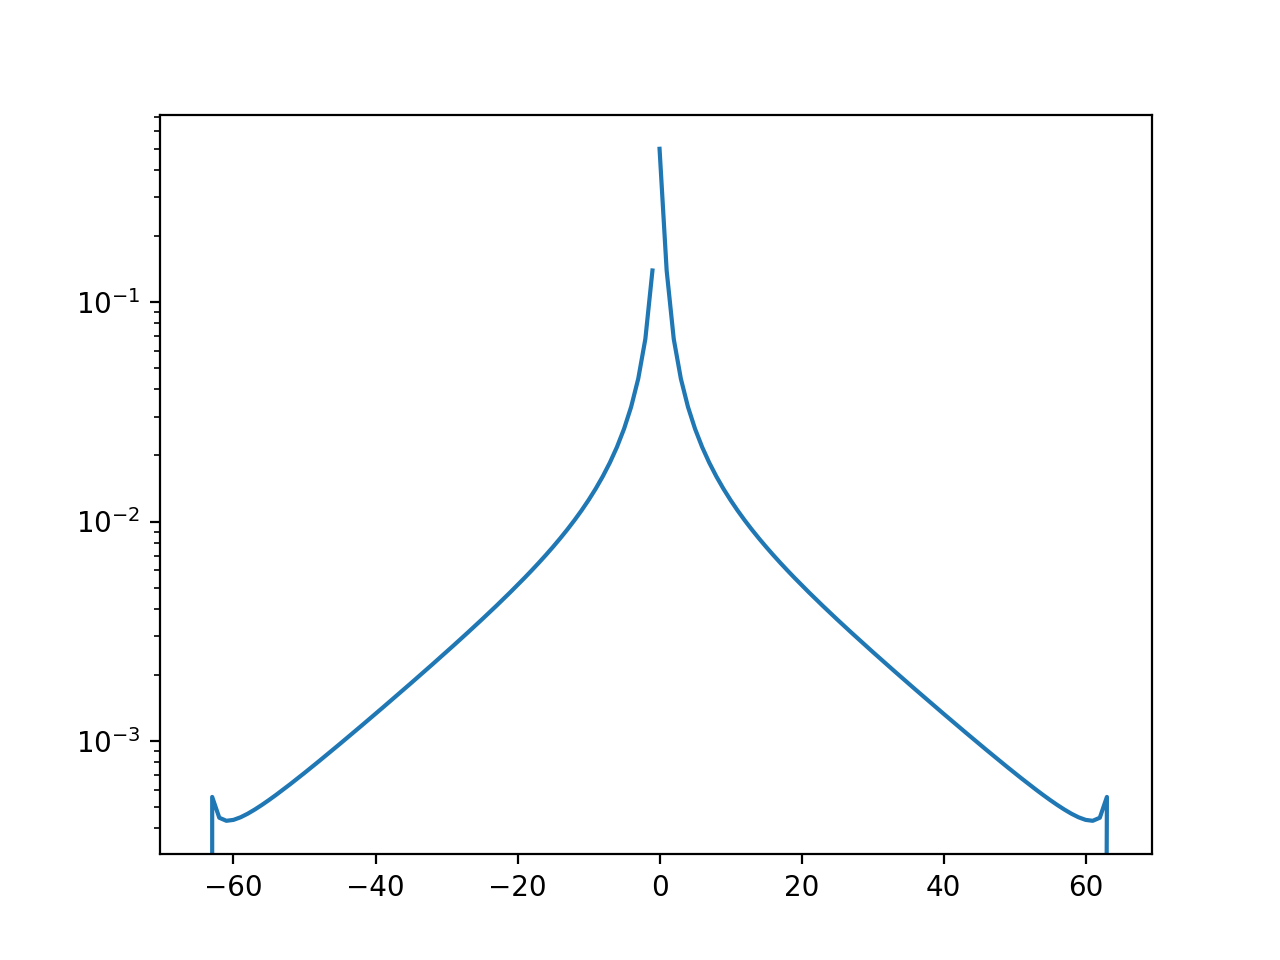

In [6]:
plt.figure()
for u, kx in zip(u_list, kx_list):
    plt.plot(kx, np.abs(u))
plt.yscale('log')

How do we do this using the `spectral.py` framework?

In [7]:
x_basis = spectral.Fourier(128)
domain = spectral.Domain([x_basis])
dtype = np.complex128
u = spectral.Field(domain, dtype=dtype)
dudx = spectral.Field(domain, dtype=dtype)
RHS = spectral.Field(domain, dtype=dtype) # -u*dudx
problem = spectral.InitialValueProblem(domain, [u], [RHS], dtype=dtype)

x = x_basis.grid()
u.require_grid_space()
u.data = 0.5*(np.sin(x)+1)

nu = 1e-2
dt = 1e-2
t_end = 5
num_steps = int(t_end/dt)

# need to specify L and M matrix
p = problem.pencils[0]

I = sparse.eye(x_basis.N)
p.M = I
diag = nu*x_basis.wavenumbers(dtype)**2
p.L = sparse.diags(diag)


In [8]:
ts = spectral.SBDF2(problem)

for i in range(num_steps):
    # need to calculate -u*ux and put it into RHS
    u.require_coeff_space()
    dudx.require_coeff_space()
    dudx.data = 1j*kx*u.data
    u.require_grid_space(scales=3/2)
    dudx.require_grid_space(scales=3/2)
    RHS.require_grid_space(scales=3/2)
    RHS.data = -u.data * dudx.data
    
    # take timestep
    ts.step(dt)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

<IPython.core.display.Javascript object>


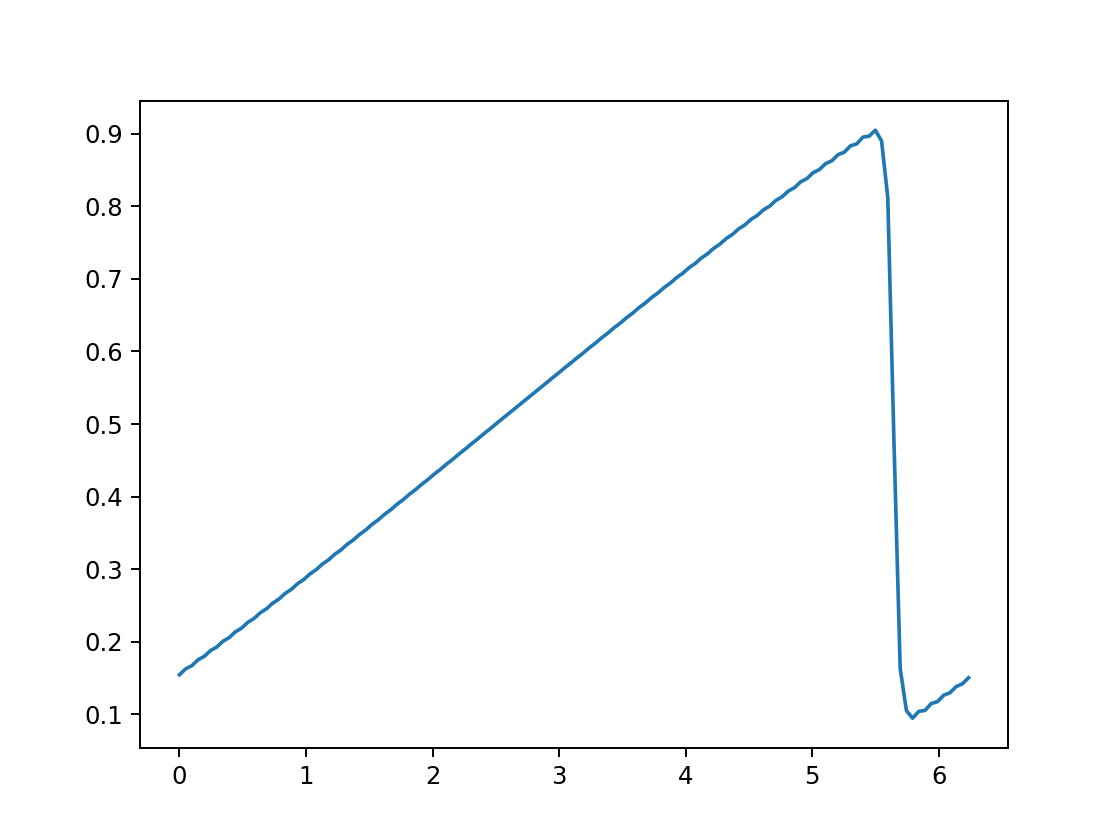

/opt/miniconda3/envs/dedalus_new/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [30]:
plt.figure()
u.require_grid_space()
plt.plot(x, u.data)

In [ ]:
u.require_grid_space()
plt.figure()
plt.plot(x, u.data)

Now let's make a class for Viscous Burgers' equation to wrap this all up.

In [5]:
class BurgersEquation:
    
    def __init__(self, domain, u, nu):
        # store data we need for later, make M and L matrices
        self.dtype = u.dtype
        dtype = self.dtype
        self.u = u
        self.domain = domain
        self.dudx = spectral.Field(domain, dtype=dtype)
        self.RHS = spectral.Field(domain, dtype=dtype) # -u*dudx
        self.problem = spectral.InitialValueProblem(domain, [self.u], [self.RHS], dtype=dtype)

        p = self.problem.pencils[0]

        x_basis = domain.bases[0]
        I = sparse.eye(x_basis.N)
        p.M = I
        diag = nu*x_basis.wavenumbers(dtype)**2
        p.L = sparse.diags(diag)
        
    def evolve(self, timestepper, dt, num_steps): # take timesteps
        ts = timestepper(self.problem)
        x_basis = self.domain.bases[0]
        u = self.u
        dudx = self.dudx
        RHS = self.RHS

        for i in range(num_steps):
            # need to calculate -u*ux and put it into RHS
            u.require_coeff_space()
            dudx.require_coeff_space()
            dudx.data = 1j*x_basis.wavenumbers(self.dtype)*u.data
            u.require_grid_space(scales=3/2)
            dudx.require_grid_space(scales=3/2)
            RHS.require_grid_space(scales=3/2)
            RHS.data = -u.data * dudx.data

            # take timestep
            ts.step(dt)

In [6]:
x_basis = spectral.Fourier(512)
domain = spectral.Domain([x_basis])
dtype = np.complex128
u = spectral.Field(domain, dtype=dtype)
u.require_grid_space()
x = x_basis.grid()
u.data = 0.5*(np.sin(x)+1)

VB = BurgersEquation(domain, u, 1e-2)

In [13]:
VB.problem.pencils[0].L

<512x512 sparse matrix of type '<class 'numpy.float64'>'
	with 512 stored elements (1 diagonals) in DIAgonal format>

In [14]:
VB.evolve(spectral.SBDF2, 1e-2, 500)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

<IPython.core.display.Javascript object>


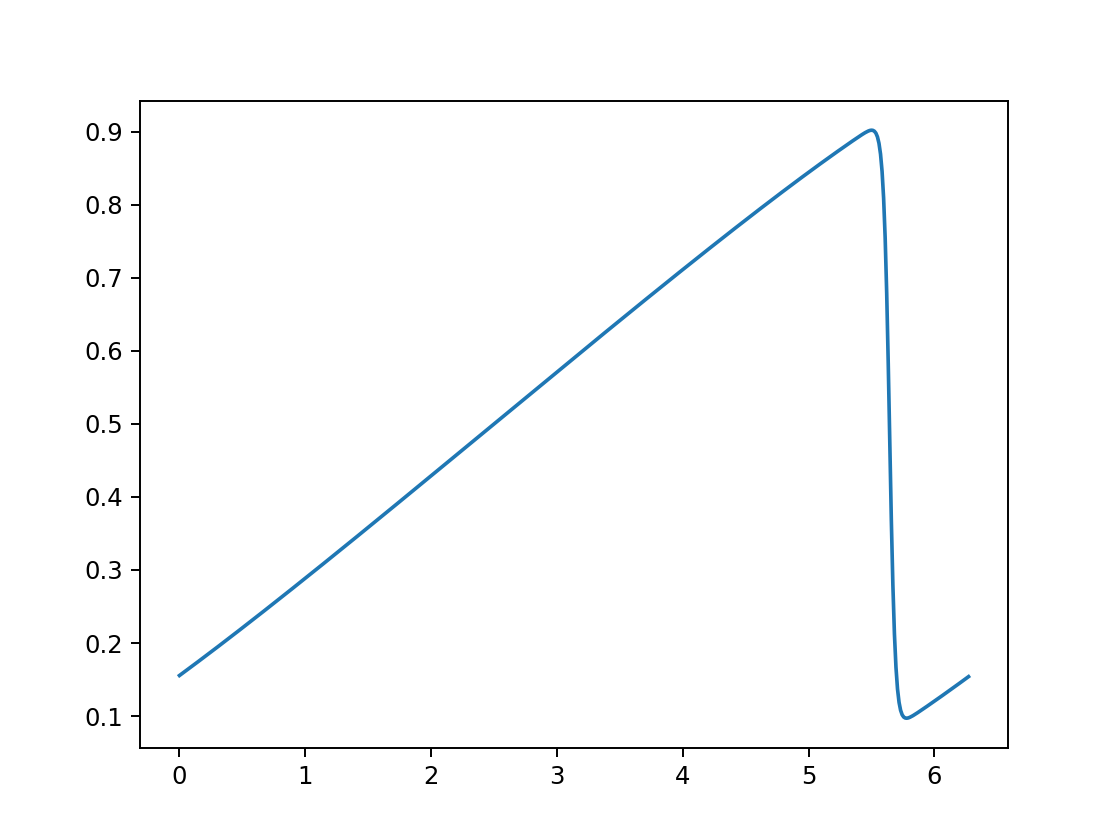

/opt/miniconda3/envs/dedalus_new/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [36]:
plt.figure()
u.require_grid_space()
plt.plot(x, u.data)